# Matrix Factorization 3

사용자의 1 건의 이전 시청 이력에서 여러 건의 시청 이력을 반영하여 보다 정확도를 높여 봅니다.

1. 시청 이력과 같은 순차 데이터를 모델링하는 신경망 모델을 알아봅니다.

2. 시청 이력을 평점 이력 마다 이전 시청 이력을 처리하기 위한 데이터 스트리밍 루틴을 구현합니다.

3. Tensorflow Custom Train 기법으로 데이터 스트리밍으로 생성이 되는 데이터를 학습해봅니다.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from IPython.display import clear_output

import gdown

dataset_path = os.environ.get('RCMD_DATASET_PATH', '../dataset')
print('Dataset path', dataset_path)
model_path = os.environ.get('RCMD_MODEL_PATH', '../model')
print('Model path', model_path)
log_path = os.environ.get('RCMD_LOG_PATH', '../logs')
print('Log path', log_path)

Dataset path ../dataset
Model path ../model
Log path ../logs


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1766222817.005987     313 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


# MovieLens32M 데이터 준비

In [3]:
# MovieLens32M 데이터 처리 모듈을 불러옵니다. (Matrix Factorization2에서의 처리 과정을 모듈로 만들었습니다.)
import movielens32m

m32m = movielens32m.load_dataset(dataset_path) # dataset 경로에 있는 movielens32m 데이터를 불러옵니다.
[i for i in m32m.keys()]

['movie_info_kr', 'movie', 'genre', 'series', 'ratings', 'movieinfo']

In [4]:
df_ratings = m32m['ratings']
s_series = m32m['series']
s_genre = m32m['genre']
df_movie = m32m['movie']
movieinfo = m32m['movieinfo']

## 사용자별 시청 이력 구조화

In [5]:
# 사용자의 이전 시점의 평가 이력을 입력 변수로 사용하기 위해
# 시점별로 정렬을 하여, 사용자 별로 시청했던 이력을 시점별로 np.array로 저장합니다.
# list에 비해 위치 기반 인덱싱이 훨씬 빠릅니다.
df_user_hist = df_ratings.sort_values('date').groupby('userId').agg(list).map(
    lambda x: np.array(x)
)

In [6]:
df_user_hist.head()

,movieId,rating,date,ts
userId,,,,
1,"[2997, 2966, 2890, 3078, 2882, 541, 838, 1136,...","[4.0, 1.0, 4.0, 2.0, 1.0, 5.0, 5.0, 1.0, 5.0, ...","[1999-11-21 23:27:26, 1999-11-21 23:27:26, 199...","[943226846000000000, 943226846000000000, 94322..."
2,"[592, 296, 380, 344, 153, 588, 349, 318, 231, ...","[4.0, 1.0, 5.0, 1.0, 3.0, 5.0, 3.0, 5.0, 2.0, ...","[1996-07-03 19:46:41, 1996-07-03 19:46:42, 199...","[836423201000000000, 836423202000000000, 83642..."
3,"[2012, 466, 2268, 168, 1544, 4306, 1485, 2617,...","[3.0, 1.0, 4.0, 3.5, 4.0, 3.5, 4.0, 4.0, 3.5, ...","[2004-05-13 21:39:14, 2004-05-13 21:39:22, 200...","[1084484354000000000, 1084484362000000000, 108..."
4,"[1210, 1833, 2745, 1272, 2115, 1327, 2826, 268...","[3.0, 2.0, 3.0, 4.0, 5.0, 3.0, 2.0, 3.0, 2.0, ...","[2000-06-08 17:27:14, 2000-06-08 17:27:14, 200...","[960485234000000000, 960485234000000000, 96048..."
5,"[592, 150, 590, 380, 296, 349, 344, 165, 588, ...","[4.0, 3.0, 3.0, 5.0, 1.0, 4.0, 3.0, 4.0, 3.0, ...","[1996-08-23 01:31:53, 1996-08-23 01:31:54, 199...","[840763913000000000, 840763914000000000, 84076..."


위에서 사용자별로 시청 이력은 시간 순으로 정렬하여 numpy array 로 만들었습니다.

구하고자 하는 시점의 위치를 구하고 이전의 hist_cnt 만큼의 데이터를 슬라이싱(Slicing)하면 됩니다.

```mermaid
graph LR
    T0[ts₀] --> T1[ts₁] --> T2[ts₂] --> T3[ts₃] --> T4[ts₄] --> T5[ts₅]
    
    %%T3:::cut --> T4 --> T5%%
    classDef cut fill:#ffd,stroke:#333,stroke-width:2px

    note1(현재 시점의 위치 seq)
    note1 --- T4

    subgraph Slicing
        T1
        T2
        T3
    end
```

In [7]:
df_user_hist.shape

(200948, 4)

## 데이터 최적화
- df_seq: df_ratings를 userId는 df_user_hist에서 위치로, movieId, date, ts 그리고 rating을 리스트의 순서로 나타냅니다.

In [8]:
df_seq = pd.concat([
    df_ratings['userId'].map({k:v for k, v in zip(df_user_hist.index, range(len(df_user_hist)))}).rename('offset'), 
    df_ratings.groupby('userId')['movieId'].transform(lambda x: np.arange(len(x))).rename('seq')
], axis=1)
df_seq

,offset,seq
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
32000199,200947,231
32000200,200947,232
32000201,200947,233
32000202,200947,234


## 학습/평가 데이터 분리

In [9]:
df_train = df_seq.loc[(df_ratings['date'] < '2022-10-13').values]
df_test = df_seq.loc[(df_ratings['date'] >= '2022-10-13').values]

len(df_train) / len(df_ratings), len(df_test) / len(df_ratings)

(0.9690947907707088, 0.030905209229291162)

In [10]:
df_rating_train = df_ratings.loc[df_ratings['date'] < '2022-10-13']
df_rating_test = df_ratings.loc[df_ratings['date'] >= '2022-10-13']

rating_train_mean = df_rating_train['rating'].astype('float64').mean()
ts_mean = df_rating_train['ts'].mean().astype('int64')
s_userCnt = df_rating_train['userId'].value_counts()
s_movieCnt = df_rating_train['movieId'].value_counts()

In [11]:
user_bins = [0, 1, 140, 500, 1000, np.inf]
s_user_type = pd.cut(
   df_rating_test['userId'].map(df_rating_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).values
display(s_user_type.value_counts())

movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
s_movie_type = pd.cut(
    df_rating_test['movieId'].map(df_rating_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
).values
s_movie_type.value_counts()

[0.0, 1.0)         698832
[1.0, 140.0)        52590
[140.0, 500.0)      88778
[500.0, 1000.0)     55604
[1000.0, inf)       93169
Name: count, dtype: int64

[0.0, 1.0)            39603
[1.0, 100.0)          77940
[100.0, 1000.0)      121152
[1000.0, 5000.0)     204978
[5000.0, 10000.0)    132723
[10000.0, inf)       412577
Name: count, dtype: int64

In [12]:
s_movie_ts_mean = df_ratings.groupby(['movieId'])['ts'].mean().astype('int64')
del df_rating_train, df_rating_test, df_ratings

In [13]:
# Matrix Factorization2에서 사용한 기반 모듈이 들어 있는 패키지를 import 합니다.
import rcmd

# 다수의 시청이력 모델링

**사용자의 평가이력 모델을 업그레이드해봅니다.**

여러개의 이력에서 패턴을 뽑아 사용자 벡터를 만들어 내는 신경망 모델을 만듭니다.

## 순환 신경망

- RNN은 과거 입력을 상태로 요약해 전달함으로써, 순서와 문맥이 중요한 데이터를 모델링하는 신경망

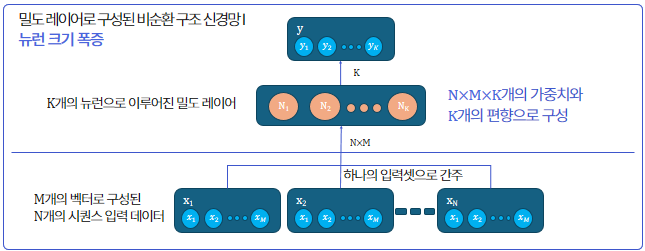

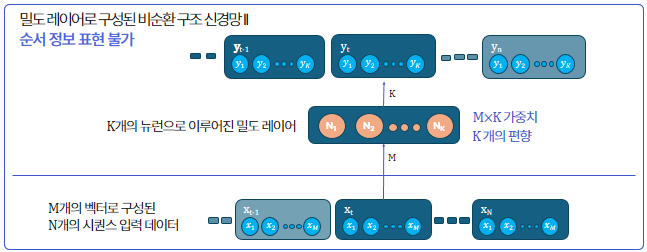

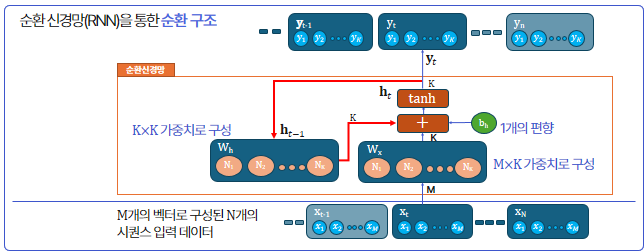

## LSTM / GRU
- RNN의 문제점
> 기울기 소실(Vanishing Gradient): 역전파 시 작은 값이 존재할 경우 기울기 소실
>
> 기울기 폭증(Vanishing Exploding): 역전파 시 큰 값이 존재할 경우 기울기 폭증 및 학습 불안정

> $\Rightarrow$ LSTM(Long Short-Term Memory), GRU(Gated Recurrent Unit)와 같은 게이트 구조 도입

- UserHistModel2에서 평가 순서를 모델링하기 위한 RNN의 기능을 확인해봅니다. 

In [14]:
rank = 32
movie_info_model = rcmd.MovieInfoModel(
    movieinfo, s_movieCnt.loc[s_movieCnt >= 100].index.values, {'movie': 32, 'collection': 8}, rank
)

In [15]:
# 3건의 영화 임베딩을 호출해봅니다.
# [1, 2, 3] 영화 평가 순서 Pattern을 뽑고 
# [3, 2, 5] 영화 평가 순서 Pattern을 뽑아
movie_info_model(tf.constant([[1, 2, 3], [3, 2, 5]]), tf.constant([[0, 0, 0], [0, 0, 0]], dtype = tf.int64))

<tf.Tensor: shape=(2, 3, 32), dtype=float32, numpy=
array([[[-1.18763492e-01,  4.86767814e-02, -9.37187672e-03,
         -1.75985843e-02,  1.27726734e-01, -8.35760981e-02,
         -1.70374960e-02,  9.74112600e-02,  1.51295543e-01,
          1.27259642e-01, -1.91834331e-01,  1.39901042e-01,
         -4.44827527e-02, -9.05064866e-02, -1.31724000e-01,
          3.59960608e-02, -5.70932999e-02,  2.34809220e-02,
          1.35869488e-01,  5.94588034e-02, -1.92135833e-02,
         -7.18528479e-02, -3.50113213e-02, -7.57304356e-02,
         -1.63395852e-01,  1.50663003e-01,  5.60905412e-02,
          4.49150838e-02,  3.49639356e-03,  8.85449350e-02,
          2.68918574e-02, -1.68649126e-02],
        [-1.21211097e-01,  6.26531765e-02,  5.57179078e-02,
          2.28800792e-02,  5.38695417e-02, -1.03565007e-02,
         -1.01789042e-01,  1.24655873e-01,  4.06778753e-02,
          1.50506467e-01, -1.99128807e-01,  9.42040682e-02,
         -8.95842630e-03, -4.59149368e-02, -8.18810984e-02,
    

In [16]:
# [1, 2] 영화 평가 순서 Pattern을 뽑고 
# [3, 2] 영화 평가 순서 Pattern을 뽑아
# [2, 2, 32]
# LSTM이라는 RNN을 사용합니다. 유닛수를 32로 설정합니다.
rnn = tf.keras.layers.LSTM(32)
# LSTM 출력 유닛으로 출력을 내어줍니다. [2, 32]
rnn(
    movie_info_model(tf.constant([[1, 2, 3], [3, 2, 5]]), tf.constant([[0, 0, 0], [0, 0, 0]], dtype = tf.int64))
)

<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[ 0.03996924,  0.0290314 ,  0.05812747, -0.01351403,  0.01749583,
        -0.02658592,  0.0180809 ,  0.04130536, -0.04179057, -0.00405599,
        -0.0338941 ,  0.0097219 ,  0.03618741,  0.02822432, -0.0226168 ,
         0.03745312, -0.00740915, -0.00106597,  0.0246061 ,  0.01200686,
        -0.01058572,  0.01452779, -0.00654826, -0.01245475, -0.01580214,
        -0.01276037, -0.0053655 , -0.00333273,  0.0257251 , -0.02837128,
        -0.00140836,  0.06647137],
       [ 0.03563429,  0.02374032,  0.05091858, -0.01094214,  0.02080905,
        -0.02033134,  0.01447788,  0.03979849, -0.0397711 , -0.00355884,
        -0.0334712 ,  0.00651221,  0.02944362,  0.02973435, -0.02327165,
         0.03045284,  0.00090928, -0.00279404,  0.02162521,  0.00639648,
        -0.00849697,  0.01586403, -0.0157315 , -0.00777553, -0.01811871,
        -0.00225049, -0.01064611,  0.00037196,  0.02488183, -0.02798777,
        -0.0056846 ,  0.05988758]], dtyp

In [17]:
# 순서를 고려하지 않는다면, 평균을 내어 패턴을 뽑는 방법을 쓸 수 있습니다.
tf.reduce_mean(
    movie_info_model(tf.constant([[1, 2, 3], [3, 2, 5]]), tf.constant([[0, 0, 0], [0, 0, 0]], dtype = tf.int64)),
    axis=-2
)

<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[-0.09323005,  0.03536183,  0.01059778,  0.01422839,  0.07589252,
        -0.03266041, -0.05871046,  0.09008178,  0.09396601,  0.0963513 ,
        -0.16695791,  0.12760094, -0.03285027, -0.05168426, -0.10887028,
         0.01671713, -0.03094834, -0.03402426,  0.12082668,  0.05773363,
         0.02674837, -0.06048383, -0.04968228, -0.05093492, -0.09640446,
         0.07534942,  0.0456421 ,  0.07581768, -0.01930946,  0.05973154,
        -0.0079221 , -0.03902309],
       [-0.08487173,  0.01078146,  0.02246681,  0.01085612,  0.06752942,
        -0.01792129, -0.06722835,  0.0767392 ,  0.07328849,  0.06765365,
        -0.14194824,  0.13689853, -0.00854701, -0.03124763, -0.10549281,
         0.0055671 , -0.03980839, -0.06608974,  0.09060138,  0.05337193,
         0.03231264, -0.07279226, -0.06042548, -0.03864269, -0.08588001,
         0.04922315,  0.036707  ,  0.08936258, -0.01582228,  0.04272727,
        -0.00195021, -0.04759696]], dtyp

# mf3: MeanModel + MFModel3

## UserHistModel2

hist_cnt 만큼의 사용자의 이전 평가 이력을 사용합니다.

- prev_movieIds: 이전에 평가한 영화 리스트
- prev_ratings: 이전 평점 리스트
- prev_ts: 이전 평가 시점 리스트

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 30
  }
}}%%
flowchart LR
    subgraph I[Inputs]
        uId(userId)
        pR(prev_ratings)
        mId(prev_movieIds)
        pts(prev_ts)
    end
    subgraph mm["<div style='white-space:nowrap;'>UserHistModel2(user_ids, user_emb_size, movie_model, output_size, hidden_units, l2=0, rnn, hist_cnt)</div>"]
        subgraph u_m["user_model:EmbModel"]
            sz1["ids: user_ids, size:user_emb_size"]
        end
        m_m["movie_model:<br/>MovieInfoModel"]

        subgraph cc2[Concatenate]
            p2[<div style='white-space:nowrap;'>axis=-1</div>]
        end
        ed["expand_dims(axis=-1)"]
        
        subgraph cc[Concatenate]
            p["<div style='white-space:nowrap;'>axis=-1<br/>M=user_emb_size+rnn['unit']"</div>]
        end

        subgraph agg[RNN]
            p3["<div style='white-space:nowrap;'>rnn=rnn['type']<br/>unit=rnn['unit']</div"]
        end

        subgraph hls[Hidden Layers]
            direction TB
            subgraph h1["H_1:Dense"]
                us1["unit_size: hidden_units[1]"]
            end
            hdot["..."]
            subgraph hn["H_n:Dense"]
                usn[unit_size: output_size]
            end
        end

        cc2-->|"Nxhist_cntx(rank+1)"|agg
        agg-->|"Nxrnn['unit']"|cc
    end
    
    output(User embedding)
    uId-->|N|u_m
    mId-->|Nxhist_cnt|m_m
    pts-->|Nxhist_cnt|m_m
    u_m-->|Nxuser_emb_size|cc
    m_m-->|Nxhist_cntxrank|cc2
    pR-->|Nxhist_cnt|ed
    ed-->|Nxhist_cntx1|cc2
    style m_m stroke-dasharray: 5

    cc-->|"NxM"|hls
    h1-->|"Nxhidden_units[1]"|hdot
    hdot-->|"Nx..."|hn
    hls-->|Nxoutput_size|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class cc layer
    class cc2 layer
    class us1 trainable
    class usn trainable
    class h1 layer
    class hdot layer
    class hn layer
```

In [18]:
class UserHistModel2(rcmd.UserHistModel):
    """
    RNN 기반 사용자 시청 이력 모델
    
    UserHistModel을 확장하여 RNN(LSTM/GRU)으로 여러 개의 시청 이력을 처리합니다.
    단일 이전 영화가 아닌 여러 개의 이력(hist_cnt개)을 시계열로 학습합니다.
    
    입력: 사용자ID + 이전 N개의 영화ID + 평점 + 시청시간
    출력: 사용자 선호 벡터
    """
    def __init__(self, user_ids, user_emb_size, movie_model, output_size, hidden_units = [], l2=0, rnn = {'type': 'lstm', 'unit': 32}, hist_cnt=8):
        """
        Args:
            user_ids: 사용자 ID 목록
            user_emb_size: 사용자 임베딩 크기
            movie_model: 영화 모델
            output_size: 출력 벡터 크기
            hidden_units: 히든 레이어 크기들
            l2: L2 정규화 계수
            rnn: RNN 설정 {'type': 'lstm'|'gru', 'unit': 크기} 또는 None (평균 사용)
            hist_cnt: 사용할 이력 개수 (기본 8개)
        """
        super().__init__(user_ids, user_emb_size, movie_model, output_size, hidden_units, l2)
        self.rnn_ = rnn
        self.hist_cnt = hist_cnt
        if rnn is None:
            self.rnn = None
        elif rnn['type'] == "lstm":
            self.rnn = tf.keras.layers.LSTM(rnn['unit'])
        elif rnn['type'] == "gru":
            self.rnn = tf.keras.layers.GRU(rnn['unit'])
        else:
            self.rnn = None
        # 각 이력 항목에 평점을 결합시킬 레이어
        self.cc2 = tf.keras.layers.Concatenate(axis=-1)

    def build(self):
        """모델 초기화"""
        self.user_model.build()
        user_model_shape = (None, self.user_model.output_size)
        if self.rnn is None:
            # RNN 없이 평균 사용 시
            hist_model_shape = (None, self.movie_model.output_size + 1)
        else:
            # RNN으로 시계열 처리
            hist_model_shape = self.rnn.compute_output_shape((None, self.hist_cnt, self.movie_model.output_size))
            self.rnn.build((None, self.hist_cnt, self.movie_model.output_size + 1))
        shape_ = self.cc.compute_output_shape([user_model_shape, hist_model_shape])
        for i in self.hidden_layers:
            i.build(shape_)
            shape_ = i.compute_output_shape(shape_)
        if self.o is not None:
            self.o.build(shape_)
        else:
            self.output_size = shape_[-1]
        
    def call(self, x, prev_movieIds, prev_ratings, prev_ts, training=False):
        """
        사용자 선호 벡터 생성 (RNN 기반)
        
        Args:
            x: 사용자 ID
            prev_movieIds: 이전 N개 영화 ID들 (N, hist_cnt) 형태
            prev_ratings: 이전 N개 평점들 (N, hist_cnt, 1) 형태
            prev_ts: 이전 N개 시청 시간들 (N, hist_cnt) 형태
            training: 학습 모드 여부
            
        Returns:
            사용자 선호 벡터
        """
        # 영화 벡터 + 평점 결합
        hist_vec = self.cc2([
            self.movie_model(prev_movieIds, prev_ts, training=training),
            prev_ratings
        ])
        if self.rnn != None:
            # RNN으로 시계열 처리
            hist_vec = self.rnn(hist_vec) # N×32
        else:
            # rnn을 사용하지 않는 경우는 평균을 사용합니다. N×(rank + 1)
            hist_vec =  tf.reduce_mean(hist_vec, axis = -2) 
        x = self.cc([
            self.user_model(x, training=training), 
            hist_vec
        ])
        for i in self.hidden_layers:
            x = i(x)
        if self.o is None:
            return x
        return self.o(x)

## MFModel3

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 35
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        pR(prev_ratings)
        pmId(prev_movieIds)
        pts(prev_ts)
        ts(ts)
    end
    subgraph mm["<div style='white-space:nowrap;'>MFModel3(user_ids, user_emb_size, user_hidden_units, rnn, hist_cnt, movieinfo, movie_ids, movie_emb_config, movie_hidden_units, rank)</div>"]
        direction LR
        subgraph u_m["user_model:UserHistModel2"]
            sz1["<div style='text-align: left;'>user_ids, user_emb_size, movie_model, rank,<br/>hidden_units, l2=0, rnn, hist_cnt</div>"]
        end
        subgraph m_m["movie_model:MovieInfoModel"]
            sz2["<div style='white-space:nowrap;'> movieinfo, movie_ids, movie_emb_config,<br/> movie_hidden_units, rank</div>"]
        end
        Rw["Dot(axis=-1)"]
    end
    
    output((Rating))
    uId-->|N|u_m
    mId-->|N|m_m
    pR-->|Nxhist_cnt|u_m
    pmId-->|Nxhist_cnt|u_m
    pts-->|Nxhist_cnt|u_m
    u_m-->|"<div style='color:red'>prev_movieIds:Nxhist_cnt</div>"|m_m
    u_m-->|"<div style='color:red'>prev_ts:Nxhist_cnt</div>"|m_m
    m_m-->|"<div style='color:red'>Nxhist_cntxrank</div>"|u_m
    ts-->|N|m_m
    u_m-->|Nxrank|Rw
    m_m-->|Nxrank|Rw
    
    Rw-->|Nx1|output
    

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class Rw layer
```

In [19]:
class MFModel3(tf.keras.Model):
    """
    RNN 기반 Matrix Factorization 모델
    
    MFModel2_2를 확장하여 여러 개의 시청 이력을 RNN으로 처리합니다.
    사용자의 최근 N개 이력을 LSTM/GRU로 학습하여 시계열 패턴을 반영합니다.
    
    구성:
    - 사용자 모델: UserHistModel2 (RNN 기반 이력 처리)
    - 영화 모델: MovieInfoModel (메타데이터 활용)
    
    공식: rating = user_hist_vector(RNN) · movie_vector
    """
    def __init__(self, 
                 user_ids, user_emb_size, user_hidden_units, rnn, hist_cnt,
                 movieinfo, movie_ids, movie_emb_config, movie_hidden_units,
                 rank
        ):
        """
        Args:
            user_ids: 사용자 ID 목록
            user_emb_size: 사용자 임베딩 크기
            user_hidden_units: 사용자 모델 히든 레이어 크기들
            rnn: RNN 설정 {'type': 'lstm'|'gru', 'unit': 크기} 또는 None
            hist_cnt: 사용할 이력 개수
            movieinfo: 영화 메타데이터
            movie_ids: 영화 ID 목록
            movie_emb_config: 영화 임베딩 설정
            movie_hidden_units: 영화 모델 히든 레이어 크기들
            rank: 최종 벡터 차원
        """
        super().__init__()
        self.user_ids = user_ids
        self.user_emb_size = user_emb_size
        self.user_hidden_units = user_hidden_units
        self.rnn = rnn
        self.hist_cnt = hist_cnt
        self.movie_ids = movie_ids
        self.movie_emb_config = movie_emb_config
        self.movie_hidden_units = movie_hidden_units
        self.rank = rank
        self.is_built = False
        
        # 영화 모델 (메타데이터 활용)
        self.movie_model = rcmd.MovieInfoModel(movieinfo, movie_ids, movie_emb_config, rank, movie_hidden_units)
        # 사용자 모델 (RNN 기반 이력 처리)
        self.user_model = UserHistModel2(user_ids, user_emb_size, self.movie_model, rank, user_hidden_units, rnn=rnn, hist_cnt=hist_cnt)
        # Row-wise dot Product를 하도록 설정합니다.
        self.dot = tf.keras.layers.Dot(axes=-1)

    def build(self):
        """모델 초기화 (중복 방지)"""
        if self.is_built:
            return
        self.user_model.build()
        self.movie_model.build()
        self.is_built = True

    def call(self, x, training=False):
        """
        평점 예측 (RNN 기반 이력 활용)
        
        Args:
            x (dict):
                - userId: 사용자 ID
                - prev_movieIds: 이전 N개 영화 ID들
                - prev_ratings: 이전 N개 평점들
                - prev_ts: 이전 N개 시청 시간들
                - movieId: 예측할 영화 ID
                - ts: 현재 시간
            training: 학습 모드 여부
            
        Returns:
            예측 평점 = user_vector(RNN) · movie_vector
        """
        x_movie = self.movie_model(
            x['movieId'], # N
            x['ts'], # N
            training=training
        ) # N×32
        x_user = self.user_model(
            x['userId'], 
            x['prev_movieIds'], 
            tf.expand_dims(x['prev_ratings'], axis=-1), 
            x['prev_ts'],
            training=training
        )
        return self.dot([x_user, x_movie])

    def get_model_data(self):
        """모델 가중치를 딕셔너리로 반환 (저장용)"""
        return {
            'user_ids': self.user_ids,
            'user_emb_size': self.user_emb_size, 
            'user_hidden_units': list(self.user_hidden_units),
            'rnn': dict(self.rnn) if self.rnn is not None else None,
            'hist_cnt': self.hist_cnt,
            'movieinfo': self.movie_model.get_movieinfo(), 
            'movie_ids': self.movie_ids,
            'movie_emb_config': dict(self.movie_emb_config),
            'movie_hidden_units': list(self.movie_hidden_units),
            'user_model': self.user_model.get_weights(),
            'movie_model': self.movie_model.get_weights(),
            'rank': self.rank
        }

    def from_model_data(model_data):
        """저장된 모델 데이터로부터 모델 복원"""
        model = MFModel3(
            model_data['user_ids'],  model_data['user_emb_size'], model_data['user_hidden_units'], model_data.get('rnn', None), model_data['hist_cnt'],
            model_data['movieinfo'], model_data['movie_ids'], model_data['movie_emb_config'], model_data['movie_hidden_units'],
            model_data['rank']
        )
        model.build()
        model.user_model.set_weights(model_data['user_model'])
        model.movie_model.set_weights(model_data['movie_model'])
        return model

    def predict_by_userid(self, x):
        """
        한 사용자에 대한 여러 영화 평점 예측
        
        call()에서는 배치별 (사용자1, 아이템1), (사용자2, 아이템2), ... 로 쌍별 계산입니다.
        그런 상황 사용자 아이디 텐서는 아이템갯수에 대한 반복을 하게 됩니다.
        이러한 상황이 비효율적인 경우 최적화를 해야하며,
        하나의 사용자에 대한 여러 아이템들의 평점을 계산합니다.
        
        Args:
            x (dict):
                - userId: 사용자 ID
                - prev_movieIds: 이전 N개 영화 ID들
                - prev_ratings: 이전 N개 평점들
                - prev_ts: 이전 N개 시청 시간들
                - movieIds: [영화 ID 리스트]
                - ts: 현재 시간
        """
        
        x_user = self.user_model(
            x['userId'],
            x['prev_movieIds'], 
            tf.expand_dims(x['prev_ratings'], axis=-1), 
            x['prev_ts'],
            training=False
        )
        # item id 행렬 user id의 임베딩을 브로드캐스트 작업시, item id 만큼 반복되는 user_emb는 매번 필요가 없는 경우 벡터와 
        # item id 만으로 매우 빠르게 연산할 수 있습니다.
        x_movie = self.movie_model(
            x['movieIds'], # N
            x['ts'], # N
            training=False
        )
        return tf.squeeze(
            tf.matmul(x_movie, x_user, transpose_b=True)
        )

    def get_user_vec(self, user_id, **argv):
        """특정 사용자의 임베딩 벡터 반환 (RNN 기반 이력 포함)"""
        return tf.squeeze(
            self.user_model(
                tf.constant([user_id]), tf.constant([argv['prev_movieIds']]), 
                tf.expand_dims(tf.constant([argv['prev_ratings']]), axis=-1), tf.constant([argv['prev_ts']])
            )
        )

    def get_item_vecs(self, item_ids, **argv):
        """여러 영화의 임베딩 벡터들 반환"""
        return self.movie_model(tf.constant(item_ids), tf.constant(argv['ts']))

In [20]:
tf.keras.backend.clear_session()
mf_model3 = MFModel3(
    s_userCnt.loc[s_userCnt >= 150].index.values, 32, [64], {'type': 'lstm', 'unit': 32}, 2,
    movieinfo, s_movieCnt.loc[s_movieCnt >= 100].index.values, {'movie': 32, 'collection': 8}, [64],
    rank = 32
)
test_input = {
    'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 'ts': tf.constant([ts_mean, ts_mean], dtype = tf.int64), 
    'prev_movieIds': tf.constant([[0, 1], [2, 3]]), 'prev_ratings': tf.constant([[1.0, 3.5], [2, 4]]), 
    'prev_ts': tf.constant([[ts_mean, ts_mean], [ts_mean, ts_mean]], dtype = tf.int64)
}
mf_model3(test_input)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.02634378],
       [0.02451004]], dtype=float32)>

In [21]:
del mf_model3

# Custom Train Step

다수의 이전 시청했던 영화 평가 이력을 미리 만들어 놓으면 상당한 메모리가 필요하게 됩니다. 

한 건당 계산해 보면,  이력의 수가 8개라고 할 때

> movieId: 4byte, rating: 4byte, timestamp: 4byte = 12byte x 8 = 96 byte
>
> 32M x 96 byte ≒ 3GByte

여기서 감당하기엔 그리 큰 크기는 아니지만 Data Augumentation 기법을 사용하여 더 큰 규모의 데이터 대응하는 기법을 보여드립니다.

## 이전의 시청 이력 만들어 내기

In [22]:
df_user_hist

,movieId,rating,date,ts
userId,,,,
1,"[2997, 2966, 2890, 3078, 2882, 541, 838, 1136,...","[4.0, 1.0, 4.0, 2.0, 1.0, 5.0, 5.0, 1.0, 5.0, ...","[1999-11-21 23:27:26, 1999-11-21 23:27:26, 199...","[943226846000000000, 943226846000000000, 94322..."
2,"[592, 296, 380, 344, 153, 588, 349, 318, 231, ...","[4.0, 1.0, 5.0, 1.0, 3.0, 5.0, 3.0, 5.0, 2.0, ...","[1996-07-03 19:46:41, 1996-07-03 19:46:42, 199...","[836423201000000000, 836423202000000000, 83642..."
3,"[2012, 466, 2268, 168, 1544, 4306, 1485, 2617,...","[3.0, 1.0, 4.0, 3.5, 4.0, 3.5, 4.0, 4.0, 3.5, ...","[2004-05-13 21:39:14, 2004-05-13 21:39:22, 200...","[1084484354000000000, 1084484362000000000, 108..."
4,"[1210, 1833, 2745, 1272, 2115, 1327, 2826, 268...","[3.0, 2.0, 3.0, 4.0, 5.0, 3.0, 2.0, 3.0, 2.0, ...","[2000-06-08 17:27:14, 2000-06-08 17:27:14, 200...","[960485234000000000, 960485234000000000, 96048..."
5,"[592, 150, 590, 380, 296, 349, 344, 165, 588, ...","[4.0, 3.0, 3.0, 5.0, 1.0, 4.0, 3.0, 4.0, 3.0, ...","[1996-08-23 01:31:53, 1996-08-23 01:31:54, 199...","[840763913000000000, 840763914000000000, 84076..."
...,...,...,...,...
200944,"[260, 1196, 318, 2571, 1291, 7153, 1210, 13413...","[4.0, 3.5, 5.0, 5.0, 3.5, 5.0, 4.0, 5.0, 3.0, ...","[2016-01-31 13:35:09, 2016-01-31 13:35:12, 201...","[1454247309000000000, 1454247312000000000, 145..."
200945,"[318, 8874, 2762, 92259, 79132, 593, 1246, 168...","[5.0, 2.5, 4.0, 5.0, 5.0, 4.0, 3.5, 4.0, 4.0, ...","[2018-01-27 16:20:23, 2018-01-27 16:20:56, 201...","[1517070023000000000, 1517070056000000000, 151..."
200946,"[10, 736, 17, 95, 6, 62, 36, 780, 25, 671, 107...","[5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 4.0, 3.0, ...","[1996-10-10 07:06:24, 1996-10-10 07:07:00, 199...","[844931184000000000, 844931220000000000, 84493..."


## Tensorflow 처리 루틴의 한계

사용자 별로 시청 이력의 수가 다르므로, 전체 사용자 시청 이력을 Array로 담아 두기에는 공간의 낭비가 큽니다.

따라서 시청이력에 차원에서의 가변의 길이를 가진 구조가 필요한데요.

이를 Ragged Tensor 라고 합니다.

Tensorflow에서는 **Ragged Tensor**가 있지만, 기능이 안정적이지 못합니다.

따라서 처리 루틴을 Tensorflow Data-pipeline으로 구현하기 힘듭니다.

따라서 compile ~ fit을 사용할 수가 없어, **Custom Train Step**

이용하여 학습을 진행시킵니다.

## 단일 프로세스 버전

In [23]:
df_train = df_train.sample(frac = 1)
hist_cnt = 8

In [24]:
# 사용자 시청 이력 로직을 파악하기 위해 학습 데이터 일부분만을 추출합니다.
i, batch_size = 0, 4
df_piece = df_train.iloc[i:i + batch_size]
display(df_piece)

,offset,seq
12084074,75592,11
3013799,19004,80
10808342,67751,214
19417573,121599,110


In [25]:
seq = df_piece['seq'].values # 리스트에서 몇번째 요소인지를 가져옵니다.
from_idx = (seq - hist_cnt).clip(0) # 이전 이력의 시작 위치를 구합니다.
null_hist_idx = (hist_cnt - seq).clip(0) # hist_cnt에서 모자란 데이터의 카운트를 구합니다.
df_hist = df_user_hist.iloc[df_piece['offset']] # 위치 기준으로 사용자의 이력을 가져옵니다.
display(df_hist)
movie_id, ts, prev_movieIds, prev_ratings, prev_ts, ratings  = list(), list(), list(), list(), list(), list()
for seq, from_idx, null_hist_idx, prev_movieIds_, prev_ts_, prev_ratings_ in zip(seq, from_idx, null_hist_idx, df_hist['movieId'].values, df_hist['ts'].values, df_hist['rating'].values):
    movie_id.append(prev_movieIds_[seq])
    ts.append(prev_ts_[seq])
    ratings.append(prev_ratings_[seq])
    prev_movieIds_ = prev_movieIds_[from_idx:seq]
    prev_ts_ =  prev_ts_[from_idx:seq]
    prev_ratings_ =  prev_ratings_[from_idx:seq]
    if null_hist_idx > 0:
        if seq == 0:
            pad_ts, pad_rating = ts_mean, rating_train_mean
        else:
            pad_ts, pad_rating = np.mean(prev_ts_), np.mean(prev_ratings_)
        prev_movieIds_ = np.pad(prev_movieIds_, (0, null_hist_idx), constant_values = 0)
        prev_ts_ = np.pad(prev_ts_, (0, null_hist_idx), constant_values = pad_ts)
        prev_ratings_ = np.pad(prev_ratings_, (0, null_hist_idx), constant_values = pad_rating)
    prev_movieIds.append(prev_movieIds_)
    prev_ratings.append(prev_ratings_)
    prev_ts.append(prev_ts_)
movie_id, ts, prev_movieIds, prev_ratings, prev_ts, ratings

,movieId,rating,date,ts
userId,,,,
75593,"[2028, 589, 111, 356, 1934, 2915, 1221, 608, 1...","[4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 5.0, 5.0, 4.0, ...","[2000-12-14 09:35:11, 2000-12-14 09:37:37, 200...","[976786511000000000, 976786657000000000, 97678..."
19005,"[317, 2987, 1517, 104, 3114, 2174, 1258, 2012,...","[3.0, 2.5, 3.5, 4.0, 3.0, 3.0, 3.5, 3.5, 3.5, ...","[2005-04-28 06:10:31, 2005-04-28 06:10:37, 200...","[1114668631000000000, 1114668637000000000, 111..."
67752,"[1884, 1458, 1210, 3108, 2944, 3039, 902, 1248...","[3.0, 4.0, 4.0, 3.0, 4.0, 3.0, 4.0, 4.0, 5.0, ...","[1999-12-11 19:08:56, 1999-12-11 19:08:56, 199...","[944939336000000000, 944939336000000000, 94493..."
121600,"[466, 112, 163, 2699, 1639, 172, 5349, 1320, 1...","[3.5, 3.5, 4.0, 4.0, 4.5, 4.5, 4.0, 3.5, 2.0, ...","[2006-09-19 22:07:10, 2006-09-19 22:07:18, 200...","[1158703630000000000, 1158703638000000000, 115..."


([np.int64(527), np.int64(8798), np.int64(3032), np.int64(3793)],
 [np.int64(976787655000000000),
  np.int64(1115020570000000000),
  np.int64(944943400000000000),
  np.int64(1158705179000000000)],
 [array([ 356, 1934, 2915, 1221,  608, 1617,  318,  593]),
  array([3556, 6618, 6597, 3897, 1213, 2959, 6796, 1089]),
  array([2866, 3152, 1955, 2971, 1964, 3135, 2877, 1380]),
  array([8874,    6,  316,  586, 1036,  919,  541, 1682])],
 [array([4., 4., 3., 5., 5., 4., 4., 5.]),
  array([4.5, 4.5, 4. , 4.5, 4.5, 4. , 4. , 4.5]),
  array([4., 5., 5., 5., 4., 5., 3., 3.]),
  array([3.5, 4. , 4. , 0.5, 4. , 5. , 5. , 5. ])],
 [array([976786657000000000, 976787026000000000, 976787026000000000,
         976787026000000000, 976787518000000000, 976787518000000000,
         976787518000000000, 976787655000000000]),
  array([1114669820000000000, 1114669897000000000, 1114669968000000000,
         1115020483000000000, 1115020486000000000, 1115020514000000000,
         1115020516000000000, 11150205610000

- MovieLens32M 준비 단계에서 사용자의 시청이력(movieId, rating)을 시청 시점(ts)순으로 정렬

→  현재 시점의 array의 위치를 찾아 이전의 hist_cnt 만큼의 이력을 만듭니다.

In [26]:
from sklearn.metrics import mean_squared_error

def train_single(a_model, df_train, hist_cnt = 8, batch_size = 1024):
    # df_train의 위치 인덱스를 batch_size 만큼씩 나눕니다.
    pos = np.hstack([np.arange(0, len(df_train), batch_size), [len(df_train) - batch_size]])
    # 데이터가 특정 범주로 편중이 되면 학습이 잘 되지 않습니다. 
    # 이를 방지하기 위해 순서를 섞어 줍니다.
    np.random.shuffle(pos)
    pbar = tqdm(pos)
    metric_mse = tf.keras.metrics.Mean()
    metric_loss = tf.keras.metrics.Mean()
    
    mse = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    # Custom Train Step
    # tf.function 데코레이터 내부에 텐서를 전달할 때에는 텐서의 스펙을 줘야 제대로된 최적화가 됩니다.
    @tf.function(
        input_signature = [
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # userId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # moveId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # ts: N
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_movieIds: Nx8
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.float32), # prev_ratings: Nx8
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_ts: Nx8
            tf.TensorSpec(shape=(None,), dtype=tf.float32) # ratings: N
        ]
    )
    def train_step(userId, movieId, ts, prev_movieIds, prev_ratings, prev_ts, rating):
        # Loss의 경사도를 계산하기 위해, 
        # Loss를 구하기 위한 연산들에서 모델들의 가중치(weight)의 경사도를 기록하게 합니다.
        with tf.GradientTape() as tape:
            prd = a_model({
                'userId': userId, 
                'movieId': movieId, 
                'ts': ts,
                'prev_movieIds': prev_movieIds, 
                'prev_ratings': prev_ratings,
                'prev_ts': prev_ts
            }, training=True)
            mse_ = mse(rating, prd)
            regularization_loss = tf.reduce_sum(a_model.losses)
            loss = mse_ + regularization_loss
        metrics = {
            'mse': mse_,
            'loss': loss,
            'regularization_loss': regularization_loss
        }
        variables = a_model.trainable_variables
        # 기록된 모델에 있는 가중치의 경사도를 가져옵니다.
        gradients = tape.gradient(loss, variables)
        # 최적화 모듈에 경사도를 전달하여 모델에 있는 가중치를 업데이트합니다.
        optimizer.apply_gradients(zip(gradients, variables))
        return metrics
    df_train = df_train.sample(frac = 1)
    for n, i in enumerate(pbar):
        piece = df_train.iloc[i:i + batch_size]
        seq = piece['seq'].values
        from_idx = (seq - hist_cnt).clip(0)
        null_hist_idx = (hist_cnt - seq).clip(0)
        df_hist = df_user_hist.iloc[piece['offset']]
        movie_id, ts, prev_movieIds, prev_ratings, prev_ts, ratings  = list(), list(), list(), list(), list(), list()
        for seq, from_idx, null_hist_idx, prev_movieIds_, prev_ts_, prev_ratings_ in zip(
            seq, from_idx, null_hist_idx, 
            df_hist['movieId'].values, df_hist['ts'].values, df_hist['rating'].values
        ):
            movie_id.append(prev_movieIds_[seq])
            ts.append(prev_ts_[seq])
            ratings.append(prev_ratings_[seq])
            prev_movieIds_ = prev_movieIds_[from_idx:seq]
            prev_ts_ =  prev_ts_[from_idx:seq]
            prev_ratings_ =  prev_ratings_[from_idx:seq]
            if null_hist_idx > 0:
                if seq == 0:
                    pad_ts, pad_rating = ts_mean, rating_train_mean
                else:
                    pad_ts, pad_rating = np.mean(prev_ts_), np.mean(prev_ratings_)
                prev_movieIds_ = np.pad(prev_movieIds_, (0, null_hist_idx), constant_values = 0)
                prev_ts_ = np.pad(prev_ts_, (0, null_hist_idx), constant_values = pad_ts)
                prev_ratings_ = np.pad(prev_ratings_, (0, null_hist_idx), constant_values = pad_rating)
            prev_movieIds.append(prev_movieIds_)
            prev_ratings.append(prev_ratings_)
            prev_ts.append(prev_ts_)

        loss = train_step(
            tf.constant(df_hist.index, dtype=tf.int64),
            tf.constant(movie_id, dtype=tf.int64),
            tf.constant(ts, dtype=tf.int64),
            tf.constant(np.vstack(prev_movieIds), dtype=tf.int64),
            tf.constant(np.vstack(prev_ratings), dtype=tf.float32),
            tf.constant(np.vstack(prev_ts), dtype=tf.int64),
            tf.constant(ratings, dtype=tf.float32)
        )
        metric_mse.update_state(loss['mse'])
        metric_loss.update_state(loss['loss'])
        pbar.set_description("mse {:.3f}, loss {:.3f}".format(metric_mse.result().numpy(), metric_loss.result().numpy()))
        
def predict_single_test(a_model, df_test, batch_size):
    pos = np.hstack([np.arange(0, len(df_test),batch_size)])
    prds = []
    pbar = tqdm(pos)
    ratings_all = list()
    for n, i in enumerate(pbar):
        piece = df_test.iloc[i:i + batch_size]
        seq = piece['seq'].values
        from_idx = (seq - hist_cnt).clip(0)
        null_hist_idx = (hist_cnt - seq).clip(0)
        df_hist = df_user_hist.iloc[piece['offset']]
        movie_id, ts, prev_movieIds, prev_ratings, prev_ts, ratings  = list(), list(), list(), list(), list(), list()
        for seq, from_idx, null_hist_idx, prev_movieIds_, prev_ts_, prev_ratings_ in zip(
            seq, from_idx, null_hist_idx, 
            df_hist['movieId'].values, df_hist['ts'].values, df_hist['rating'].values
        ):
            movie_id.append(prev_movieIds_[seq])
            ts.append(prev_ts_[seq])
            ratings.append(prev_ratings_[seq])
            prev_movieIds_ = prev_movieIds_[from_idx:seq]
            prev_ts_ =  prev_ts_[from_idx:seq]
            prev_ratings_ =  prev_ratings_[from_idx:seq]
            if null_hist_idx > 0:
                if seq == 0:
                    pad_ts, pad_rating = ts_mean, rating_train_mean
                else:
                    pad_ts, pad_rating = np.mean(prev_ts_), np.mean(prev_ratings_)
                prev_movieIds_ = np.pad(prev_movieIds_, (0, null_hist_idx), constant_values = 0)
                prev_ts_ = np.pad(prev_ts_, (0, null_hist_idx), constant_values = pad_ts)
                prev_ratings_ = np.pad(prev_ratings_, (0, null_hist_idx), constant_values = pad_rating)
            prev_movieIds.append(prev_movieIds_)
            prev_ratings.append(prev_ratings_)
            prev_ts.append(prev_ts_)
        prd = a_model({
            'userId': tf.constant(df_hist.index, dtype=tf.int64), 
            'movieId': tf.constant(movie_id, dtype=tf.int64), 
            'ts': tf.constant(ts, dtype=tf.int64), 
            'prev_movieIds': tf.constant(np.vstack(prev_movieIds), dtype=tf.int64), 
            'prev_ratings': tf.constant(np.vstack(prev_ratings), dtype=tf.float32),
            'prev_ts': tf.constant(np.vstack(prev_ts), dtype=tf.int64)
        })
        prds.append(prd.numpy())
        ratings_all.append(ratings)
    return np.hstack(ratings_all), np.squeeze(np.vstack(prds))

"""
# 단일 Process 버전의 학습 루틴입니다. 
# 본 노트에서는 실행을 완료 시켜 전체의 결과를 뽑아 냈지만,
# 이후에 나오는 병렬화 버젼과 동일한 모델을 동일한 데이터로 학습시키는 것입니다.
# 따라서, 이 모델의 학습 결과를 확인하기 위함이라면,
# 본 셀은 생략하고 아래의 병렬화 과정을 사용하면 됩니다.

verbose = True
epochs = 1
hist_cnt = 8
# 병렬화 효율의 극대화를 하고자 한다면 GPU 메모리가 허용하는 수준의 batch size를 증가시키면 됩니다.
# batch_size=1024 세팅은 GPU 메모리 크기가 4GB를 기준으로 만든 것입니다.
batch_size = 1024
tf.keras.backend.clear_session()

mean_model = rcmd.MeanModel(
    rating_train_mean, 
    s_userCnt.loc[s_userCnt > 1].index.values, 
    s_movieCnt.loc[s_movieCnt > 1].index.values
)
mf_model3 = MFModel3(
    s_userCnt.loc[s_userCnt >= 150].index.values, 32, [64], {'type': 'lstm', 'unit': 32}, hist_cnt,
    movieinfo, s_movieCnt.loc[s_movieCnt >= 100].index.values, {'movie': 32, 'collection': 8}, [64],
    rank = 32
)
a_model = rcmd.AdditiveModel([mf_model3, mean_model])
mse_test, mse_by_userCnt, mse_by_movieCnt = list(), list(), list()
for i in range(epochs):
    train_single(a_model, df_train, hist_cnt, batch_size)
    true, prds = predict_single_test(a_model, df_test, batch_size)
    if verbose:
        # 테스트셋의 성능을 구합니다.
        mse_test.append(mean_squared_error(true, prds))
        # 테스트셋 성능을 묶어 데이터프레임을 만듭니다.
        df_prd = pd.DataFrame({'rating': true, 'prds': prds})
        # 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
        mse_by_userCnt.append(
            df_prd.groupby(s_user_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )
        # 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
        mse_by_movieCnt.append(
            df_prd.groupby(s_movie_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )
        # 종합하여 하나의 데이터프레임으로 만듭니다.
        df_result = pd.concat([
            pd.DataFrame({('', 'test'): mse_test}),
            pd.concat(mse_by_userCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['userCnt'], x.index.tolist()]))
            ).T,
            pd.concat(mse_by_movieCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['movieCnt'], x.index.tolist()]))
            ).T
        ], axis=1)
        df_result.index = np.arange(1, len(df_result) + 1)
        df_result.name = 'epoch'
        clear_output()
        display(df_result)
del a_model, mean_model, mf_model3
"""
''

''

## 멀티 프로세스 버전

병렬처리를 통한 사용자가 이전에 평가한 N개의 이력을 가져오게 루틴을 구성했습니다.

이렇게하여 CPU에서 처리하는 이력 추출 작업에 의한 Bottle Neck 현상에 대응할 수 있습니다.

여기에서는 뚜렷한 효과는 없지만, 멀티 프레세스를 통한 데이터 증강 기법을 소개하는 차원에서 다루겠습니다.

```mermaid
sequenceDiagram
    participant Main as Main Process
    participant Split as hist_set_iter
    participant W1 as Worker 1
    participant W2 as Worker 2
    participant Wdot as Worker ...
    participant WN as Worker N
    participant Q as Result Queue

    Main->>Split: hist_set_iter
    Split->>W1: Batch 1
    Split->>W2: Batch 2
    Split->>Wdot: Batch ...
    Split->>WN: Batch N

    W1->>Q: 시청이력 추가 Batch
    W2->>Q: 시청이력 추가 Batch
    Wdot->>Q: 시청이력 추가 Batch
    WN->>Q: 시청이력 추가 Batch

    Q-->>Split: 시청이력 추가 Batch
    Split->>Main:yield
```

In [27]:
from multiprocessing import Process, Queue
# 이전 히스토리를 가져오는 부분을 Process화 합니다.
class BatchWoker(Process):
    def __init__(self, q, df, df_user_hist, pos, hist_cnt, batch_size, rating_mean, ts_mean):
        self.q = q
        self.hist_cnt = hist_cnt
        self.batch_size = batch_size
        self.df = df
        self.df_user_hist = df_user_hist
        self.pos = pos
        self.rating_mean = rating_mean
        self.ts_mean = ts_mean
        super().__init__()
    def run(self):
        for i in self.pos:
            piece = self.df.iloc[i:i + self.batch_size]
            seq = piece['seq'].values
            from_idx = (seq - hist_cnt).clip(0)
            null_hist_idx = (hist_cnt - seq).clip(0)
            df_hist = self.df_user_hist.iloc[piece['offset']]
            movie_id, ts, prev_movieIds, prev_ratings, prev_ts, ratings  = list(), list(), list(), list(), list(), list()
            for seq, from_idx, null_hist_idx, prev_movieIds_, prev_ts_, prev_ratings_ in zip(
                seq, from_idx, null_hist_idx, 
                df_hist['movieId'].values, df_hist['ts'].values, df_hist['rating'].values
            ):
                movie_id.append(prev_movieIds_[seq])
                ts.append(prev_ts_[seq])
                ratings.append(prev_ratings_[seq])
                prev_movieIds_ = prev_movieIds_[from_idx:seq]
                prev_ts_ =  prev_ts_[from_idx:seq]
                prev_ratings_ =  prev_ratings_[from_idx:seq]
                if null_hist_idx > 0:
                    if seq == 0:
                        pad_ts, pad_rating = self.ts_mean, self.rating_mean
                    else:
                        pad_ts, pad_rating = np.mean(prev_ts_), np.mean(prev_ratings_)
                    prev_movieIds_ = np.pad(prev_movieIds_, (0, null_hist_idx), constant_values = 0)
                    prev_ts_ = np.pad(prev_ts_, (0, null_hist_idx), constant_values = pad_ts)
                    prev_ratings_ = np.pad(prev_ratings_, (0, null_hist_idx), constant_values = pad_rating)
                prev_movieIds.append(prev_movieIds_)
                prev_ratings.append(prev_ratings_)
                prev_ts.append(prev_ts_)
            batch = (df_hist.index, movie_id, ts, prev_movieIds, prev_ratings, prev_ts, ratings)
            self.q.put(batch)
        self.q.put(None) # 할당량을 채웠을 경우에 None을 반환합니다.

In [28]:
def hist_set_iter(df, df_user_hist, hist_cnt, batch_size, 
                  pbar=None, shuffle=True, n_job=4, queue_size=16, rating_mean=0.0, ts_mean = 0.0, equal_batch_size=True
    ):
    """
        Multiprocessing을 통해 Batch 데이터를 만들어 내는 Iterator

        df: pd.DataFrame
            rating 데이터프레임
        df_user_hist: pd.DataFrame
            이력 데이터
        pos: list
            위치 인덱스 리스트
        hist_cnt: int
            이전 평가 이력 수
        batch_size: int
            배치(Batch) 사이즈
        pbar: Tqdm
            Progress 표시기
        shuffle: bool
            데이터를 섞음 여부
        n_job: int
            Process 수
        queue_size: int
            Queue 사이즈
        default_rating: float
            이력 평점이 결측일 경우의 대체할 평점
        equal_batch_size: bool
            마지막 부분의 배치사이즈를 동일하게 맞출지 여부
    """
    if len(df) % batch_size != 0 and equal_batch_size:
        # 전체셋 크기가 batch_size에 나누어 떨어지지 않으면
        # 동일한 Batch 사이즈를 위해 마지막은 끝에서 batch_size만큼 뺀 위치 부터 가져옵니다.
        pos = np.hstack([np.arange(0, len(df) - batch_size, batch_size), [len(df) - batch_size]])
    else:
        pos = np.arange(0, len(df), batch_size)
    chunk = (len(pos) + n_job - 1) // n_job
    if shuffle:
        np.random.shuffle(pos)
    # Work Process 에서 작업한 결과를 저장할 Queue입니다.
    q = Queue(queue_size)
    # n_jobs 만큼 Worker를 생성합니다.
    workers = list()
    for i in range(0, len(pos), chunk):
        workers.append(BatchWoker(q, df, df_user_hist, pos[i: i + chunk], hist_cnt, batch_size, rating_mean, ts_mean))
        workers[-1].start()
    job_finished = 0
    if pbar is not None:
        pbar.total = len(pos)
    while(True):
        val = q.get()
        if val == None: # Worker가 작업을 마치면 None을 반환합니다.
            job_finished +=1 # 작업이 끝난 Worker 카운트
            if job_finished == len(workers): # 모든 Worker가 작업을 끝냈다면 중지
                break
            continue
        yield(val)
        if pbar is not None:
            pbar.update(1)

# mf3의 학습과 검증

In [29]:
from sklearn.metrics import mean_squared_error

def train(a_model, df_train, learning_rate, hist_cnt = 8, batch_size = 1024, n_job = 4):
    # df_train의 위치 인덱스를 batch_size 만큼씩 나눕니다.
    metric_mse = tf.keras.metrics.Mean()
    metric_loss = tf.keras.metrics.Mean()
    
    mse = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # tf.function은 내부의 Tensorflow 연산을 그래프로 정형화하여 속도 향상을 시킵니다.
    @tf.function(
        input_signature = [
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # userId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # moveId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # ts: N
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_movieIds: N×hist_cnt
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.float32), # prev_ratings: N×hist_cnt
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_ts: N×hist_cnt
            tf.TensorSpec(shape=(None,), dtype=tf.float32) # ratings: N
        ]
    )
    def train_step(userId, movieId, ts, prev_movieIds, prev_ratings, prev_ts, rating):
        # Loss의 경사도를 계산하기 위해, 
        # Loss를 구하기 위한 연산들에서 모델들의 가중치(weight)의 경사도를 기록하게 합니다.
        with tf.GradientTape() as tape:
            prd = a_model({
                'userId': userId, 
                'movieId': movieId, 
                'ts': ts,
                'prev_movieIds': prev_movieIds, 
                'prev_ratings': prev_ratings,
                'prev_ts': prev_ts,
            }, training=True)
            mse_ = mse(rating, prd)
            regularization_loss = tf.reduce_sum(a_model.losses)
            loss = mse_ + regularization_loss
        metrics = {
            'mse': mse_,
            'loss': loss,
            'regularization_loss': regularization_loss
        }
        variables = a_model.trainable_variables
        # 기록된 모델에 있는 가중치의 경사도를 가져옵니다.
        gradients = tape.gradient(loss, variables)
        # 최적화 모듈에 경사도를 전달하여 모델에 있는 가중치를 업데이트합니다.
        optimizer.apply_gradients(zip(gradients, variables))
        return metrics

    with tqdm() as pbar:
        for i in hist_set_iter(
            df_train.sample(frac = 1), df_user_hist, hist_cnt, batch_size, pbar, shuffle=False, n_job = n_job, rating_mean=rating_train_mean, ts_mean=ts_mean, equal_batch_size=True
        ):
            # 사용자 / 영화 / 추출한 평가이력 / 점수를 train_step에 전달합니다.
            loss = train_step(
                tf.constant(i[0], dtype=tf.int64), # userId
                tf.constant(i[1], dtype=tf.int64), # movieID
                tf.constant(i[2], dtype=tf.int64), # ts
                tf.constant(i[3], dtype=tf.int64), # prev_movieIds
                tf.constant(i[4], dtype=tf.float32), # prev_ratings
                tf.constant(i[5], dtype=tf.int64), # prev_ts
                tf.constant(i[6], dtype=tf.float32), # rating
            )
            metric_mse.update_state(loss['mse'])
            metric_loss.update_state(loss['loss'])
            pbar.set_description("mse {:.3f}, loss {:.3f}".format(metric_mse.result().numpy(), metric_loss.result().numpy()))

def predict_test(a_model, df_test, hist_cnt = 8, batch_size = 1024):
    prds = list()
    ratings_all = list()
    with tqdm() as pbar:
        for i in hist_set_iter(df_test, df_user_hist, hist_cnt, batch_size, pbar, shuffle=False, n_job=1, rating_mean=rating_train_mean, ts_mean=ts_mean, equal_batch_size=False):
            prd = a_model({
                'userId': tf.constant(i[0], dtype=tf.int64), 
                'movieId': tf.constant(i[1], dtype=tf.int64), 
                'ts': tf.constant(i[2], dtype=tf.int64),
                'prev_movieIds': tf.constant(i[3], dtype=tf.int64), 
                'prev_ratings': tf.constant(i[4], dtype=tf.float32),
                'prev_ts': tf.constant(i[5], dtype=tf.int64),
            })
            prds.append(prd.numpy())
            ratings_all.append(i[6])
    return np.hstack(ratings_all), np.squeeze(np.vstack(prds))

**모델 구성**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 40
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        ts(ts)
        pR(prev_ratings)
        pmId(prev_movieIds)
        pts(prev_ts)
    end
    subgraph AM["a_model:AdditiveModel"]
        direction LR
        subgraph mm["mean_model:MeanModel"]
            direction LR
            param1[<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 1회 넘는 userId</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 1회 넘는 movieId</div></div>]
        end
        subgraph mf["mf_model3:MFModel3"]
            direction LR
            param3["<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 150회 넘는 userId</div><br/><div style='white-space:nowrap;'>user_emb_size: 32</div><br/><div style='white-space:nowrap;'>user_hidden_units: [64]</div><br/><div style='white-space:nowrap;'>movieinfo: movieinfo</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 100회 넘는 movieId</div><br/><div style='white-space:nowrap;'>movie_emb_config:{'movie':32, 'collection': 8}</div><br/><div style='white-space:nowrap;'>movie_hidden_units: [64]</div><br/><div style='white-space:nowrap;'>output_size: 32</div><br/><div style='white-space:nowrap;'>rnn: LSTM, units: 32</div></div>"]
        end
    end
    output((Rating))

    uId-->|N|AM
    mId-->|N|AM
    ts-->|N|AM
    pmId-->|Nx8|AM
    pR-->|Nx8|AM
    pts-->|Nx8|AM
    AM-->|N|output
```

In [30]:
# mf3.pkl 이 없으면 학습을 하고, 학습 산출물을 mf3.pkl에 저장합니다.
# mf3.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
model_filename = os.path.join(model_path, 'mf3.pkl')
"""
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=18jDrElizg4ww_7bfKnuWwc3oo5sPLXwY", quiet=False)
    os.rename(o, model_filename)
"""
if not os.path.isfile(model_filename):
    epochs, hist_cnt, verbose = 10, 8, True
    # 모델 인스턴스를 만듭니다.
    tf.keras.backend.clear_session()
    mean_model = rcmd.MeanModel(
        rating_train_mean, 
        s_userCnt.loc[s_userCnt > 1].index.values, 
        s_movieCnt.loc[s_movieCnt > 1].index.values
    )
    mf_model3 = MFModel3(
        s_userCnt.loc[s_userCnt >= 140].index.values, 32, [64], {'type': 'lstm', 'unit': 32}, hist_cnt,
        movieinfo, s_movieCnt.loc[s_movieCnt >= 100].index.values, {'movie': 32, 'collection': 8}, [64],
        rank = 32
    )
    a_model = rcmd.AdditiveModel([mf_model3, mean_model])
    a_model.build()
    display(a_model.summary())
    # 병렬화 효율의 극대화를 하고자 한다면 GPU 메모리가 허용하는 수준의 batch size를 증가시키면 됩니다.
    # batch_size=1024 세팅은 GPU 메모리 크기가 4GB를 기준으로 만든 것입니다.
    batch_size = 1024
    mse_test, mse_by_userCnt, mse_by_movieCnt = list(), list(), list()
    for i in range(epochs):
        train(a_model, df_train, 2e-5, hist_cnt, batch_size)
        true, prds = predict_test(a_model, df_test, hist_cnt, batch_size)
        if verbose:
            # 테스트셋의 성능을 구합니다.
            mse_test.append(mean_squared_error(true, prds))
            # 테스트셋 성능을 묶어 데이터프레임을 만듭니다.
            df_prd = pd.DataFrame({'rating': true, 'prds': prds})
            # 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
            mse_by_userCnt.append(
                df_prd.groupby(s_user_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
            )
            # 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
            mse_by_movieCnt.append(
                df_prd.groupby(s_movie_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
            )
            # 종합하여 하나의 데이터프레임으로 만듭니다.
            df_result = pd.concat([
                pd.DataFrame({('', 'test'): mse_test}),
                pd.concat(mse_by_userCnt, axis=1).pipe(
                    lambda x: x.set_index(pd.MultiIndex.from_product([['userCnt'], x.index.tolist()]))
                ).T,
                pd.concat(mse_by_movieCnt, axis=1).pipe(
                    lambda x: x.set_index(pd.MultiIndex.from_product([['movieCnt'], x.index.tolist()]))
                ).T
            ], axis=1)
            df_result.index = np.arange(1, len(df_result) + 1)
            df_result.name = 'epoch'
            clear_output()
            display(df_result)
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'mean_model': mean_model.get_model_data(),
            'mf_model3': mf_model3.get_model_data(),
            'result': df_result
        }, f)
else:
    with open(model_filename, 'rb') as f:
        mf3 = pickle.load(f)
    # 학습 결과를 출력합니다.
    df_result = mf3['result']
    display(df_result)
    # 모델을 재구성합니다.
    tf.keras.backend.clear_session()
    mean_model = rcmd.MeanModel.from_model_data(mf3['mean_model'])
    mf_model3 = MFModel3.from_model_data(mf3['mf_model3'])
    a_model = rcmd.AdditiveModel([mean_model, mf_model3])
    del mf3

userCnt                                              \
        test [0.0, 1.0) [1.0, 140.0) [140.0, 500.0) [500.0, 1000.0)   
1   0.657249   0.674086     0.659249       0.619632        0.594158   
2   0.650418   0.669688     0.652944       0.604536        0.581992   
3   0.642069   0.662355     0.646848       0.590464        0.570090   
4   0.636396   0.657086     0.641273       0.582577        0.563109   
5   0.634206   0.655807     0.637793       0.577914        0.559027   
6   0.630607   0.651985     0.635998       0.574691        0.555778   
7   0.627948   0.648982     0.633082       0.573427        0.554144   
8   0.631473   0.655598     0.634800       0.569418        0.549709   
9   0.625767   0.648445     0.631126       0.568015        0.547432   
10  0.625487   0.649683     0.629556       0.564407        0.542581   

                   movieCnt                                                \
   [1000.0, inf) [0.0, 1.0) [1.0, 100.0) [100.0, 1000.0) [1000.0, 5000.0)   
1       0.603326   0.692182     0.697915        0.668122         0.656089   
2       0.589015   0.683684     0.688079        0.658921         0.648532   
3       0.579339   0.676804     0.679082        0.649819         0.639361   
4       0.573477   0.671782     0.672206        0.643045         0.633283   
5       0.568666   0.667648     0.669656        0.641417         0.631644   
6       0.565152   0.664027     0.665472        0.637121         0.627754   
7       0.563277   0.662970     0.662601        0.634012         0.624960   
8       0.556572   0.655955     0.665582        0.639626         0.630373   
9       0.554423   0.654642     0.658510        0.631324         0.623241   
10      0.549385   0.650295     0.657503        0.631413         0.623673   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
1           0.648933       0.646272  
2           0.642703       0.641033  
3           0.633904       0.633438  
4           0.628154       0.628481  
5           0.626305       0.625997  
6           0.622792       0.622832  
7           0.620168       0.620247  
8           0.624819       0.622974  
9           0.618658       0.618721  
10          0.618935       0.618326

## mf3 결과 확인

In [31]:
import scann
scann_index = scann.scann_ops.builder(
    np.vstack([
        a_model.get_item_vecs(df_movie.index[i: i + 1024], ts = ts_mean).numpy()
        for i in range(0, len(df_movie.index), 1024)
    ]), 1000, 'dot_product'
).tree(
    num_leaves=1000, num_leaves_to_search=100, training_sample_size=100000
).score_ah(
    2, anisotropic_quantization_threshold=0.2
).reorder(1000).build()

I0000 00:00:1766222925.575081     313 partitioner_factory_base.cc:58] Size of sampled dataset for training partition: 87510
W0000 00:00:1766222925.596239     313 gmm_utils.cc:1026] Could not normalize centroid due to zero norm or empty or zero-weight partition.
I0000 00:00:1766222918.347911     313 kmeans_tree_partitioner_utils.h:90] PartitionerFactory ran in -7.227258825s.


In [32]:
a_model.get_user_vec(
    1,
    **df_user_hist.loc[1].pipe(
        lambda x: {'prev_movieIds': x['movieId'][-8:], 'prev_ratings': x['rating'][-8:], 'prev_ts': x['ts'][-8:]}
    )
)

<tf.Tensor: shape=(33,), dtype=float32, numpy=
array([ 1.        ,  0.0478594 , -0.08937299,  0.6462176 , -0.07226126,
        0.28822374,  0.9515571 , -0.4538691 ,  0.18872482,  0.59346074,
       -0.7642496 , -0.21673071, -0.40081224,  0.9791136 , -0.50838935,
       -0.5629809 ,  0.37379488,  0.3727239 , -0.0253456 ,  0.19315189,
        0.7920596 ,  0.5701922 , -0.73596555, -0.34074196,  1.2043904 ,
        0.0445018 ,  0.7080776 , -0.28124586, -0.43987992,  0.03262054,
        0.26521316,  0.3317063 , -0.68043727], dtype=float32)>

In [33]:
userId = 171796
labels, sims = scann_index.search(
    a_model.get_user_vec(
        userId,
        **df_user_hist.loc[userId].pipe(
            lambda x: {'prev_movieIds': x['movieId'][-8:], 'prev_ratings': x['rating'][-8:], 'prev_ts': x['ts'][-8:]}
        )
    )
)
df_movie.iloc[labels[:10].numpy(), :2]

,title,genres
movieId,,
166024,Whiplash (2013),(no genres listed)
167832,The Invisible Guest (2016),Thriller
160289,O.J.: Made in America (2016),Documentary
231701,Kill Bill: The Whole Bloody Affair (2011),Action|Crime
116411,Tangerines (2013),Drama
183423,AlphaGo (2017),Documentary
158783,The Handmaiden (2016),Drama|Romance|Thriller
202749,Portrait of a Lady on Fire (2019),Drama|Romance
81845,"King's Speech, The (2010)",Drama


In [34]:
a_model.summary()

Model: "additive_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mean_model (MeanModel)          │ ?                      │       258,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mf_model3 (MFModel3)            │ ?                      │     2,381,784 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,640,420 (10.07 MB)

 Trainable params: 2,640,420 (10.07 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
true, prds = predict_test(a_model, df_test, hist_cnt, 1024)
df_prd = pd.DataFrame({'rating': true, 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
s_type_dic = {
    i: str(i) for i in s_user_type.categories
}
s_type_dic[s_user_type.categories[1]] = '[1.0, 기준 빈도)'
s_type_dic[s_user_type.categories[2]] = '[기준 빈도, 500)'
s_mf_user = df_prd.groupby(
    s_user_type.map(s_type_dic, na_action = None), observed=True
).apply(lambda x: mean_squared_error(x['rating'], x['prds'])).pipe(
    lambda x: pd.Series(x.values, index=(pd.MultiIndex.from_product([['MSE By User freq.'], [str(i) for i in x.index]])))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
s_type_dic = {
    i: str(i) for i in s_movie_type.categories
}
s_type_dic[s_movie_type.categories[1]] = '[1.0, 기준 빈도)'
s_type_dic[s_movie_type.categories[2]] = '[기준 빈도, 500)'
s_mf_movie = df_prd.groupby(
    s_movie_type.map(s_type_dic, na_action = None), observed=True
).apply(lambda x: mean_squared_error(x['rating'], x['prds'])).pipe(
    lambda x: pd.Series(x.values, index=(pd.MultiIndex.from_product([['MSE By Movie freq.'], [str(i) for i in x.index]])))
)

df_mf3_model = pd.concat([
    pd.Series(["User:UserHistModel2, Movie: MovieInfoModel", '2,526,468', mean_squared_error(df_prd['rating'], df_prd['prds']) ], 
              index = pd.MultiIndex.from_product([['모델'], ['모델 구성', 'Param. #', 'Overall MSE']])),
    pd.Series([140, 100], 
              index = pd.MultiIndex.from_product([['임베딩 기준 빈도'], ['사용자 ', '영화']])),
    s_mf_user, s_mf_movie
], axis = 0).rename('mf3').to_frame().T
df_mf3_model.to_pickle(os.path.join(log_path, 'mf3_result.pkl'))
display(pd.concat([
    pd.read_pickle(os.path.join(log_path, 'mf_result.pkl')),
    pd.read_pickle(os.path.join(log_path, 'mf2_result.pkl')),
    pd.read_pickle(os.path.join(log_path, 'mf2_2_result.pkl')),
    df_mf3_model
]))

100%|██████████| 966/966 [00:42<00:00, 22.98it/s]


모델                         \
                                              모델 구성   Param. # Overall MSE   
mf                   User:EmbModel, Movie: EmbModel  2,767,916    0.884668   
mf2             User:UserHistModel, Movie: EmbModel  2,497,164    0.767747   
mf2_2  User:UserHistModel_ts, Movie: MovieInfoModel  2,630,964     0.74568   
mf3      User:UserHistModel2, Movie: MovieInfoModel  2,526,468    0.625533   

      임베딩 기준 빈도      MSE By User freq.                            \
           사용자    영화        [0.0, 1.0) [1.0, 기준 빈도) [기준 빈도, 500)   
mf          120  100          0.964167     0.883657     0.701548   
mf2         140  100          0.811058     0.739168     0.675314   
mf2_2       140  100          0.780461      0.73156     0.663864   
mf3         140  100          0.649752     0.629555     0.564398   

                                    MSE By Movie freq.               \
      [500.0, 1000.0) [1000.0, inf)         [0.0, 1.0) [1.0, 기준 빈도)   
mf           0.616853      0.632527           1.094392     1.030031   
mf2          0.619061      0.635826           0.959313      0.89603   
mf2_2        0.634624      0.637008           1.067523     0.870911   
mf3          0.542573      0.549371           0.650284     0.657552   

                                                                      
      [기준 빈도, 500) [1000.0, 5000.0) [5000.0, 10000.0) [10000.0, inf)  
mf        0.915573         0.887832          0.848913       0.837931  
mf2       0.788705         0.777882          0.741083       0.722512  
mf2_2     0.763801         0.749385          0.710634       0.695242  
mf3        0.63148         0.623736          0.618994       0.618359

In [36]:
# 영화 임베딩을 프로젝션해봅니다.

from tensorboard.plugins import projector

# 프로젝션 데이터가 저장될 경로를 만듭니다.
log_dir=os.path.join(log_path, 'm32m_3')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# 메타데이터를 저장합니다.
known = []
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in s_movieCnt.loc[s_movieCnt > 100].index:
        if i in m32m['movie_info_kr']:
            f.write("{}\n".format(df_movie.loc[i, 'title']))
            known.append(i)

# 내용을 저장합니다.
weights =  tf.Variable(
    movie_info_model(tf.constant(known), tf.constant(s_movie_ts_mean.loc[known].astype('int64'), dtype=tf.int64))
)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [37]:
# %tensorboard --logdir logs/m32m_3/ --bind_all

In [38]:
del a_model, mean_model, mf_model3

# nn3: NNModel

Matrix Factorization 동일한 입력으로 Neural Network를 구성합니다. 그리고 성능을 확인합니다.

## NNModel3

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 35
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        pR(prev_ratings)
        pmId(prev_movieIds)
        pts(prev_ts)
        ts(ts)
    end
    subgraph mm["<div style='white-space:nowrap;'>NNModel3(user_ids, user_emb_size, user_hidden_units, rnn, hist_cnt,movieinfo, movie_ids, movie_emb_config, movie_hidden_units, hidden_units)</div>"]
        direction LR
        subgraph u_m["user_model:UserHistModel2"]
            sz1["<div style='text-align: left;'>user_ids, user_emb_size, movie_model, rank,<br/>hidden_units, l2=0, rnn, hist_cnt</div>"]
        end
        subgraph m_m["movie_model:MovieInfoModel"]
            sz2["<div style='white-space:nowrap;'> movieinfo, movie_ids, movie_emb_config,<br/> movie_hidden_units, rank</div>"]
        end

        subgraph cc["Concatenate"]
            pa["axis=-1<br/>M=user_hidden_units[-1]+<br/>  movie_hidden_units[-1]"]
        end
        
        subgraph hls[Hidden Layers]
            direction TB
            subgraph h1["H_1:Dense"]
                us1["unit_size: hidden_units[1]"]
            end
            hdot["..."]
            subgraph hn["H_n:Dense"]
                usn["unit_size: hidden_units[n]"]
            end
        end
        subgraph o["Output:Dense"]
            uo[unit_size:1]
        end
    end
    
    output((Rating))
    uId-->|N|u_m
    mId-->|N|m_m
    pR-->|Nxhist_cnt|u_m
    pmId-->|Nxhist_cnt|u_m
    pts-->|Nxhist_cnt|u_m
    u_m-->|"<div style='color:red'>prev_movieIds:Nxhist_cnt</div>"|m_m
    u_m-->|"<div style='color:red'>prev_ts:Nxhist_cnt</div>"|m_m
    m_m-->|"<div style='color:red'>Nxhist_cntx(rank+1)</div>"|u_m
    ts-->|N|m_m
    u_m-->|Nxrank|cc
    m_m-->|Nxrank|cc
    
    cc-->|NxM|hls
    h1-->|"Nxhidden_units[1]"|hdot
    hdot-->|"Nx..."|hn
    hls-->|"Nxhidden_units[n]"|o
    o-->|Nx1|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class cc layer
    class o layer
    class us1 trainable
    class usn trainable
    class uo trainable
    class h1 layer
    class hdot layer
    class hn layer
```

In [39]:
class NNModel3(tf.keras.Model):
    """
    Neural Network 기반 추천 모델
    
    MFModel3와 달리 dot product 대신 DNN(Deep Neural Network)으로 평점을 예측합니다.
    사용자 벡터와 영화 벡터를 concatenate한 후 히든 레이어를 거쳐 평점을 출력합니다.
    
    구성:
    - 사용자 모델: UserHistModel2 (RNN 기반 이력 처리)
    - 영화 모델: MovieInfoModel (메타데이터 활용)
    - DNN: concatenate([user_vec, movie_vec]) → hidden layers → rating
    
    공식: rating = DNN(concat(user_vector(RNN), movie_vector))
    """
    def __init__(self, 
                 user_ids, user_emb_size, user_hidden_units, rnn, hist_cnt,
                 movieinfo, movie_ids, movie_emb_config, movie_hidden_units,
                 hidden_units, l2 = 0
        ):
        """
        Args:
            user_ids: 사용자 ID 목록
            user_emb_size: 사용자 임베딩 크기
            user_hidden_units: 사용자 모델 히든 레이어 크기들
            rnn: RNN 설정 {'type': 'lstm'|'gru', 'unit': 크기} 또는 None
            hist_cnt: 사용할 이력 개수
            movieinfo: 영화 메타데이터
            movie_ids: 영화 ID 목록
            movie_emb_config: 영화 임베딩 설정
            movie_hidden_units: 영화 모델 히든 레이어 크기들
            hidden_units: DNN 히든 레이어 크기들 (최종 평점 예측용)
            l2: L2 정규화 계수
        """
        super().__init__()
        self.user_ids = user_ids
        self.user_emb_size = user_emb_size
        self.user_hidden_units = user_hidden_units
        self.rnn = rnn
        self.movie_ids = movie_ids
        self.movie_emb_config = movie_emb_config
        self.movie_hidden_units = movie_hidden_units
        self.hidden_units = hidden_units
        self.hist_cnt = hist_cnt
        self.is_built = False
        
        # 영화 모델 (메타데이터 활용)
        self.movie_model = rcmd.MovieInfoModel(movieinfo, movie_ids, movie_emb_config, 0, movie_hidden_units)
        # 사용자 모델 (RNN 기반 이력 처리)
        self.user_model = UserHistModel2(user_ids, user_emb_size, self.movie_model, 0, user_hidden_units, rnn=rnn, hist_cnt=hist_cnt)
        # 사용자 벡터와 영화 벡터 결합
        self.cc = tf.keras.layers.Concatenate(axis=-1)

        # L2 정규화 설정
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
        
        # 히든 레이어들 (결합된 벡터를 처리)
        self.hidden_layers = [
            tf.keras.layers.Dense(
                i, activation='relu', 
                kernel_initializer=tf.keras.initializers.HeNormal(), 
                kernel_regularizer=reg
            ) for i in hidden_units
        ]
        
        # 출력층: 평점 예측 (1개 값)
        self.o = tf.keras.layers.Dense(
            1, kernel_initializer = tf.keras.initializers.GlorotNormal(), kernel_regularizer=reg
        )

    def build(self):
        """모델 초기화 (중복 방지)"""
        if self.is_built:
            return
        self.movie_model.build()
        self.user_model.build()
        # Concatenate 후 shape: (None, user_vec_size + movie_vec_size)
        shape_ = (None, self.movie_model.output_size + self.user_model.output_size)
        for i in self.hidden_layers:
            i.build(shape_)
            shape_ = i.compute_output_shape(shape_)
        self.o.build(shape_)
        self.is_built = True
        
    def call(self, x, training=False):
        """
        평점 예측 (DNN 기반)
        
        Args:
            x (dict):
                - userId: 사용자 ID
                - prev_movieIds: 이전 N개 영화 ID들
                - prev_ratings: 이전 N개 평점들
                - prev_ts: 이전 N개 시청 시간들
                - movieId: 예측할 영화 ID
                - ts: 현재 시간
            training: 학습 모드 여부
            
        Returns:
            예측 평점 (DNN 출력)
        """
        x_movie = self.movie_model(
            x['movieId'], # N
            x['ts'], # N
            training=training
        ) # N×32
        x_user = self.user_model(
            x['userId'], 
            x['prev_movieIds'], 
            tf.expand_dims(x['prev_ratings'], axis=-1), 
            x['prev_ts'],
            training=training
        )
        # 사용자 벡터와 영화 벡터 결합
        x_movie = self.movie_model(x['movieId'], x['ts'], training=training)
        x = self.cc([x_movie, x_user])
        # DNN 히든 레이어들 통과
        for i in self.hidden_layers:
            x = i(x)
        # 평점 출력
        return self.o(x)

    def get_model_data(self):
        """모델 가중치를 딕셔너리로 반환 (저장용)"""
        return {
            'user_ids': self.user_ids,
            'user_emb_size': self.user_emb_size, 
            'user_hidden_units': list(self.user_hidden_units),
            'rnn': dict(self.rnn) if self.rnn is not None else None,
            'hist_cnt': self.hist_cnt,
            'movieinfo': self.movie_model.get_movieinfo(), 
            'movie_ids': self.movie_ids,
            'movie_emb_config': dict(self.movie_emb_config),
            'movie_hidden_units': list(self.movie_hidden_units),
            'weights': self.get_weights(),
            'hidden_units': list(self.hidden_units)
        }

    def from_model_data(model_data):
        """저장된 모델 데이터로부터 모델 복원"""
        model = NNModel3(
            model_data['user_ids'],  model_data['user_emb_size'], model_data['user_hidden_units'], model_data.get('rnn', None), model_data['hist_cnt'],
            model_data['movieinfo'], model_data['movie_ids'], model_data['movie_emb_config'], model_data['movie_hidden_units'],
            model_data['hidden_units']
        )
        model.build()
        model.set_weights(model_data['weights'])
        return model

## NN3 모델의 학습과 검증

**모델 구성**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 40
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        ts(ts)
        pR(prev_ratings)
        pmId(prev_movieIds)
        pts(prev_ts)
    end
    subgraph AM["a_model:AdditiveModel"]
        direction LR
        subgraph mm["mean_model:MeanModel"]
            direction LR
            param1[<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 1회 넘는 userId</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 1회 넘는 movieId</div></div>]
        end
        subgraph mf["nn_model3:NNModel3"]
            direction LR
            param3["<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 150회 넘는 userId</div><br/><div style='white-space:nowrap;'>user_emb_size: 32</div><br/><div style='white-space:nowrap;'>user_hidden_units: []</div><br/><div style='white-space:nowrap;'>movieinfo: movieinfo</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 100회 넘는 movieId</div><br/><div style='white-space:nowrap;'>movie_emb_config:{'movie':32, 'collection': 8}</div><br/><div style='white-space:nowrap;'>movie_hidden_units: []</div><br/><div style='white-space:nowrap;'>output_size: 32</div><br/><div style='white-space:nowrap;'>rnn: LSTM, units: 32</div><br/><div style='white-space:nowrap;'>hidden_units: [128, 64]</div></div>"]
        end
    end
    output((Rating))

    uId-->|N|AM
    mId-->|N|AM
    ts-->|N|AM
    pmId-->|Nx8|AM
    pR-->|Nx8|AM
    pts-->|Nx8|AM
    AM-->|N|output
```

In [45]:
# nn3.pkl 이 없으면 학습을 하고, 학습 산출물을 nn3.pkl에 저장합니다.
# nn3.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
model_filename = os.path.join(model_path, 'nn3.pkl')
"""
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=1QNV41mL_mT9cXLWX4ShPYiLrnbhDwXEh", quiet=False)
    os.rename(o, model_filename)
"""
if not os.path.isfile(model_filename):
    epochs, hist_cnt, verbose = 10, 8, True
    # 모델 인스턴스를 만듭니다.
    tf.keras.backend.clear_session()
    mean_model = rcmd.MeanModel(
        rating_train_mean, 
        s_userCnt.loc[s_userCnt > 1].index.values, 
        s_movieCnt.loc[s_movieCnt > 1].index.values
    )
    nn_model3 = NNModel3(
        s_userCnt.loc[s_userCnt >= 140].index.values, 32, [], {'type': 'lstm', 'unit': 32}, hist_cnt,
        movieinfo, s_movieCnt.loc[s_movieCnt >= 100].index.values, {'movie': 64, 'collection': 8}, [],
        hidden_units = [128, 64]
    )
    a_model = rcmd.AdditiveModel([nn_model3, mean_model])

    # 병렬화 효율의 극대화를 하고자 한다면 GPU 메모리가 허용하는 수준의 batch size를 증가시키면 됩니다.
    # batch_size=1024 세팅은 GPU 메모리 크기가 4GB를 기준으로 만든 것입니다.
    batch_size = 1024
    mse_test, mse_by_userCnt, mse_by_movieCnt = list(), list(), list()
    for i in range(epochs):
        train(a_model, df_train, 2e-5, hist_cnt, batch_size)
        true, prds = predict_test(a_model, df_test, hist_cnt, batch_size)
        if verbose:
            # 테스트셋의 성능을 구합니다.
            mse_test.append(mean_squared_error(true, prds))
            # 테스트셋 성능을 묶어 데이터프레임을 만듭니다.
            df_prd = pd.DataFrame({'rating': true, 'prds': prds})
            # 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
            mse_by_userCnt.append(
                df_prd.groupby(s_user_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
            )
            # 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
            mse_by_movieCnt.append(
                df_prd.groupby(s_movie_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
            )
            # 종합하여 하나의 데이터프레임으로 만듭니다.
            df_result = pd.concat([
                pd.DataFrame({('', 'test'): mse_test}),
                pd.concat(mse_by_userCnt, axis=1).pipe(
                    lambda x: x.set_index(pd.MultiIndex.from_product([['userCnt'], x.index.tolist()]))
                ).T,
                pd.concat(mse_by_movieCnt, axis=1).pipe(
                    lambda x: x.set_index(pd.MultiIndex.from_product([['movieCnt'], x.index.tolist()]))
                ).T
            ], axis=1)
            df_result.index = np.arange(1, len(df_result) + 1)
            df_result.name = 'epoch'
            clear_output()
            display(df_result)
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'mean_model': mean_model.get_model_data(),
            'nn_model3': nn_model3.get_model_data(),
            'result': df_result
        }, f)
else:
    with open(model_filename, 'rb') as f:
        nn3 = pickle.load(f)
    # 학습 결과를 출력합니다.
    df_result = nn3['result']
    display(df_result)
    # 모델을 재구성합니다.
    tf.keras.backend.clear_session()
    mean_model = rcmd.MeanModel.from_model_data(nn3['mean_model'])
    nn_model3 = NNModel3.from_model_data(nn3['nn_model3'])
    a_model = rcmd.AdditiveModel([mean_model, nn_model3])
    del nn3

userCnt                                              \
        test [0.0, 1.0) [1.0, 140.0) [140.0, 500.0) [500.0, 1000.0)   
1   0.656865   0.672559     0.661847       0.618857        0.596722   
2   0.649581   0.664998     0.653438       0.609587        0.591857   
3   0.643673   0.660893     0.647077       0.599152        0.582662   
4   0.636483   0.656250     0.640832       0.586457        0.568114   
5   0.631279   0.652584     0.636064       0.576286        0.557756   
6   0.628720   0.651432     0.632733       0.570062        0.551137   
7   0.624986   0.649000     0.630480       0.564589        0.542699   
8   0.622031   0.646898     0.627263       0.559334        0.536312   
9   0.622004   0.648391     0.626867       0.555750        0.531201   
10  0.616948   0.643000     0.623308       0.550493        0.525447   

                   movieCnt                                                \
   [1000.0, inf) [0.0, 1.0) [1.0, 100.0) [100.0, 1000.0) [1000.0, 5000.0)   
1       0.608454   0.701896     0.700233        0.668800         0.654403   
2       0.604324   0.696728     0.691121        0.659672         0.646585   
3       0.591419   0.683858     0.684104        0.654684         0.641792   
4       0.574226   0.671041     0.674600        0.646975         0.634253   
5       0.565057   0.665589     0.667661        0.640926         0.628992   
6       0.558299   0.661333     0.663928        0.638013         0.627087   
7       0.548430   0.649692     0.657542        0.633333         0.623686   
8       0.543462   0.648710     0.653069        0.629400         0.620682   
9       0.538658   0.645118     0.653066        0.630124         0.622020   
10      0.535883   0.643814     0.646166        0.622105         0.615516   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
1           0.647434       0.645103  
2           0.639766       0.638891  
3           0.635033       0.632657  
4           0.628710       0.626492  
5           0.623314       0.621979  
6           0.621457       0.619357  
7           0.618323       0.616803  
8           0.615395       0.614248  
9           0.616348       0.613344  
10          0.610895       0.609995

## nn3: 결과 확인

- 밀도신경망은 Matrix Factorization 보다 서비스 단계에서 많이 느리지만, 유연하게 모델을 구성할 수 있습니다.

- 여기에서, 밀도신경망의 성능은 Matrix Factorization 모델과 많이 미세하게 나마 앞서고 있음을 알 수 있습니다.

- 하지만 더 많은 요소와 데이터를 사용한다면 NN은 MF를 어느 순간 능가하는 성능을 낼 수 있습니다.

In [46]:
movie_cnt = len(df_movie)
user_id = 149489
prd = a_model.predict(
    tf.data.Dataset.from_tensor_slices(
        {'userId': [user_id] * movie_cnt, 'movieId': df_movie.index.tolist(), 'ts': [df_user_hist.loc[149489, 'ts'][-1]] * movie_cnt, 
         **df_user_hist.loc[user_id].pipe(
            lambda x: {'prev_movieIds': [x['movieId'][-8:]] * movie_cnt, 'prev_ratings': [x['rating'][-8:]] * movie_cnt, 'prev_ts': [x['ts'][-8:]] * movie_cnt}
        )}
    ).batch(4096), verbose = 0
)
df_movie.iloc[np.argsort(-np.squeeze(prd))[:10]]

,title,genres,release_date
movieId,,,
182723,Cosmos: A Spacetime Odissey,(no genres listed),1517431020000000000
228099,Firefly (2002),Action|Adventure|Sci-Fi|Western,1604648637000000000
94024,Louis Theroux: The Most Hated Family in Americ...,Documentary,1313280000000000000
252710,Attack On Titan (2013),Action|Adventure|Animation|Fantasy|Sci-Fi,1624748131000000000
171011,Planet Earth II (2016),Documentary,1492501570000000000
170705,Band of Brothers (2001),Action|Drama|War,1491363751000000000
241566,Hornblower: Retribution (2001),Adventure|Drama,987292800000000000
147268,Hornblower: The Even Chance (1998),Action|Adventure|Drama|War,907718400000000000
174703,I Am So Proud of You (2008),Action|Animation|Sci-Fi|Thriller,1222387200000000000


In [49]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
true, prds = predict_test(a_model, df_test, hist_cnt, 1024)
df_prd = pd.DataFrame({'rating': true, 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
s_type_dic = {
    i: str(i) for i in s_user_type.categories
}
s_type_dic[s_user_type.categories[1]] = '[1.0, 기준 빈도)'
s_type_dic[s_user_type.categories[2]] = '[기준 빈도, 500)'
s_mf_user = df_prd.groupby(
    s_user_type.map(s_type_dic, na_action = None), observed=True
).apply(lambda x: mean_squared_error(x['rating'], x['prds'])).pipe(
    lambda x: pd.Series(x.values, index=(pd.MultiIndex.from_product([['MSE By User freq.'], [str(i) for i in x.index]])))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
s_type_dic = {
    i: str(i) for i in s_movie_type.categories
}
s_type_dic[s_movie_type.categories[1]] = '[1.0, 기준 빈도)'
s_type_dic[s_movie_type.categories[2]] = '[기준 빈도, 500)'
s_mf_movie = df_prd.groupby(
    s_movie_type.map(s_type_dic, na_action = None), observed=True
).apply(lambda x: mean_squared_error(x['rating'], x['prds'])).pipe(
    lambda x: pd.Series(x.values, index=(pd.MultiIndex.from_product([['MSE By Movie freq.'], [str(i) for i in x.index]])))
)

df_nn3_model = pd.concat([
    pd.Series(["User:UserHistModel2, Movie: MovieInfoModel, Hidden: [128, 64]", '2,526,468', mean_squared_error(df_prd['rating'], df_prd['prds']) ], 
              index = pd.MultiIndex.from_product([['모델'], ['모델 구성', 'Param. #', 'Overall MSE']])),
    pd.Series([140, 100], 
              index = pd.MultiIndex.from_product([['임베딩 기준 빈도'], ['사용자 ', '영화']])),
    s_mf_user, s_mf_movie
], axis = 0).rename('nn3').to_frame().T
df_nn3_model.to_pickle(os.path.join(log_path, 'nn3_result.pkl'))
display(pd.concat([
    pd.read_pickle(os.path.join(log_path, 'mf_result.pkl')),
    pd.read_pickle(os.path.join(log_path, 'mf2_result.pkl')),
    pd.read_pickle(os.path.join(log_path, 'mf2_2_result.pkl')),
    df_mf3_model,
    df_nn3_model
]))

100%|██████████| 966/966 [00:28<00:00, 33.56it/s]


모델             \
                                                   모델 구성   Param. #   
mf                        User:EmbModel, Movie: EmbModel  2,767,916   
mf2                  User:UserHistModel, Movie: EmbModel  2,497,164   
mf2_2       User:UserHistModel_ts, Movie: MovieInfoModel  2,630,964   
mf3           User:UserHistModel2, Movie: MovieInfoModel  2,526,468   
nn3    User:UserHistModel2, Movie: MovieInfoModel, Hi...  2,526,468   

                  임베딩 기준 빈도      MSE By User freq.                            \
      Overall MSE      사용자    영화        [0.0, 1.0) [1.0, 기준 빈도) [기준 빈도, 500)   
mf       0.884668       120  100          0.964167     0.883657     0.701548   
mf2      0.767747       140  100          0.811058     0.739168     0.675314   
mf2_2     0.74568       140  100          0.780461      0.73156     0.663864   
mf3      0.625533       140  100          0.649752     0.629555     0.564398   
nn3      0.616948       140  100             0.643     0.623308     0.550493   

                                    MSE By Movie freq.               \
      [500.0, 1000.0) [1000.0, inf)         [0.0, 1.0) [1.0, 기준 빈도)   
mf           0.616853      0.632527           1.094392     1.030031   
mf2          0.619061      0.635826           0.959313      0.89603   
mf2_2        0.634624      0.637008           1.067523     0.870911   
mf3          0.542573      0.549371           0.650284     0.657552   
nn3          0.525447      0.535883           0.643814     0.646166   

                                                                      
      [기준 빈도, 500) [1000.0, 5000.0) [5000.0, 10000.0) [10000.0, inf)  
mf        0.915573         0.887832          0.848913       0.837931  
mf2       0.788705         0.777882          0.741083       0.722512  
mf2_2     0.763801         0.749385          0.710634       0.695242  
mf3        0.63148         0.623736          0.618994       0.618359  
nn3       0.622105         0.615516          0.610895       0.609995

In [43]:
del a_model, mean_model, nn_model3

# 추천의 과제

## 추천 시스템의 문제

### Selection Bias

매니아 아이템:                                                                                                                                                           
- 관심 있는 소수만 선택 → 높은 평점 (예: 4.5점), 평점수: 50개
- 선택하지 않은 대다수의 낮은 평가는 누락

대중적 아이템:
- 다양한 사람들이 선택 → 평균적 평점 (예: 3.8점), 평점수: 10,000개
- 관심 없는 사람도 시도 → 낮은 평점 포함

평점기반의 추천기는 관심 있는 소수만 선택,

> $\Large \displaystyle Rating = \text{User's score}|\text{User selected the Item}$
>
> **Berkson's Paradox**: 조건부 확률에서 발생하는 역설적 현상

반면, 선택 확률 기반의 추천기는 대중적 아이템만 선택
> 선택은 했지만, 그 선택의 결과는 평점으로 드러납니다.


### Filter Bubble

사용자가 자신의 기존 선호도와 유사한 콘텐츠만 반복적으로 추천받으면서 정보의 다양성이 감소하고 새로운 경험의 기회가 제한되는 현상입니다.

#### 발생 원인
**지나친 개인화 (Over-personalization)**
> 추천 시스템이 사용자의 과거 행동 패턴을 너무 충실히 학습
> 
> 유사한 아이템만 계속 추천 (exploitation 편향)

**피드백 루프 (Feedback Loop)**
> 사용자 시청 → 추천 학습 → 유사 콘텐츠 추천 → 사용자 시청 → ...
>
> 선호도가 점점 좁아지는 자기강화 순환

## 문제의 접근 방향: 다양화

**데이터의 다양화**: Implicit Feeback과 Explicit Feedback

**속성의 다양화**: 계절, 일자, 시간, 요일, 날씨, 사용자 프로필 ...

**기법의 다양화**: MF, NN, 콘텐츠 기반, ...

**전략의 다양화**, ...